<div style="text-align: center;">
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Created with Inkscape (http://www.inkscape.org/) by Marsupilami -->
<svg
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   version="1.1"
   width="512"
   height="212"
   viewBox="-2.33857497 -2.33857497 199.55840994 82.62964894"
   id="svg11878">
  <defs
     id="defs11880" />
  <path
     d="m 0,0 194.88125,0 0,77.9525 L 0,77.9525 0,0 z"
     id="path11744"
     style="fill:#ffffff;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 76.6875,17.24375 0,0.9325 2.9675,0 0,9.16375 1.11375,0 0,-9.16375 2.98375,0 0,-0.9325 -7.065,0 z m 9.32875,0 0,10.09625 5.49,0 0,-0.9325 -4.36,0 0,-3.83 3.94875,0 0,-0.93375 -3.94875,0 0,-3.4675 4.36,0 0,-0.9325 -5.49,0 z m 12.93,0.635 c 0.96875,0 1.82125,0.195 2.61625,0.7225 l 0.42875,-0.81 c -0.94875,-0.495 -1.88625,-0.76875 -3.045,-0.76875 -2.985,0 -5.335,2.15125 -5.335,5.2325 0,3.285 2.3475,5.23125 5.335,5.23125 1.0225,0 2.10625,-0.39375 3,-0.8975 l -0.40125,-0.72 c -0.78875,0.43875 -1.70375,0.7625 -2.59875,0.7625 -2.4525,0 -4.18375,-1.9525 -4.18375,-4.37625 0,-2.425 1.73125,-4.37625 4.18375,-4.37625 m 5.6025,-0.635 0,10.09625 1.13,0 0,-4.8375 5.50375,0 0,4.8375 1.1225,0 0,-10.09625 -1.1225,0 0,4.3425 -5.50375,0 0,-4.3425 -1.13,0 z m 12.53,-0.2325 -1.1725,0.3 0,10.02875 1.07875,0 -0.005,-8.6675 5.93625,8.89 1.19125,-0.32875 0,-9.99 -1.05,0 -0.02,8.66125 -5.95875,-8.89375 z M 128.1975,27.34 l 1.12125,0 0,-10.0975 -1.12125,0 0,10.0975 z m 6.87875,-0.61625 c -0.785,0 -1.59,-0.34125 -2.14875,-0.71125 l -0.45,0.7325 c 0.815,0.49 1.62125,0.745 2.6725,0.745 2.19625,0 3.21625,-1.37625 3.21625,-2.845 0,-1.53875 -1.0925,-2.1875 -2.24625,-2.7425 l -0.84875,-0.40625 c -0.73625,-0.37125 -1.51875,-0.85375 -1.51875,-1.805 0,-1.31 1.08,-1.90125 2.005,-1.90125 0.94375,0 1.5575,0.3325 2.14,0.71 l 0.39,-0.74125 c -0.78,-0.4525 -1.63875,-0.735 -2.58875,-0.735 -1.78125,0 -3.00875,1.07875 -3.00875,2.5925 0,2.1125 1.54625,2.495 3.0325,3.2125 0.8175,0.39375 1.49125,0.88875 1.49125,1.92 0,1.21 -0.8875,1.975 -2.1375,1.975 m 11.08875,-8.845 c 0.96875,0 1.8225,0.195 2.61625,0.7225 l 0.42875,-0.81 c -0.94875,-0.495 -1.88625,-0.76875 -3.045,-0.76875 -2.985,0 -5.335,2.15125 -5.335,5.2325 0,3.285 2.3475,5.23125 5.335,5.23125 1.0225,0 2.10625,-0.39375 3,-0.8975 l -0.4025,-0.72 c -0.7875,0.43875 -1.7025,0.7625 -2.5975,0.7625 -2.4525,0 -4.18375,-1.9525 -4.18375,-4.37625 0,-2.425 1.73125,-4.37625 4.18375,-4.37625 m 5.9375,-0.635 0,10.09625 1.13,0 0,-4.8375 5.50375,0 0,4.8375 1.12125,0 0,-10.09625 -1.12125,0 0,4.3425 -5.50375,0 0,-4.3425 -1.13,0 z m 11.35375,0 0,10.09625 5.49875,0 0,-0.9325 -4.36,0 0,-3.83 3.94875,0 0,-0.9325 -3.94875,0 0,-3.46875 4.36,0 0,-0.9325 -5.49875,0 z m -77.76,23.32625 0,-6.6225 -1.13,0 0,6.45875 c 0,2.265 -1.0925,2.98 -2.835,2.98 -1.91125,0 -2.7175,-1.0425 -2.7175,-2.98 l 0,-6.45875 -1.1625,0 0.03,6.72 c 0,2.3025 1.355,3.55375 3.85,3.55375 1.89625,0 3.965,-0.6075 3.965,-3.65125 m 4.36875,-6.84625 -1.1725,0.29875 0,10.03 1.07875,0 -0.005,-8.6675 5.93625,8.89 1.19125,-0.32875 0,-9.99 -1.05,0 -0.02,8.66125 -5.95875,-8.89375 z m 10.57125,10.32875 1.13,0 0,-10.105 -1.13,0 0,10.105 z m 4.41375,-10.26 -1.0975,0.34625 3.85625,9.91375 1.115,0 3.88,-9.89875 -1.0725,-0.35875 -3.335,9.0625 -3.34625,-9.065 z m 9.93375,0.155 0,10.105 5.49,0 0,-0.9325 -4.36,0 0,-3.83 3.94,0 0,-0.93375 -3.94,0 0,-3.47625 4.36,0 0,-0.9325 -5.49,0 z m 10.61875,4.92875 -1.34625,0 0,-4.05375 1.6275,0 c 1.74,0 2.26,0.85125 2.26,2.015 0,1.6075 -1.25625,2.03875 -2.54125,2.03875 m 0.56625,-4.92 -3.05125,-0.0075 0,10.1125 1.13875,0 0,-4.35125 0.925,0 c 0.74625,0 1.13125,0.27375 1.57125,0.81125 l 0.43375,0.555 2.37125,3.23125 0.98625,-0.59 -1.99875,-2.645 c -0.3925,-0.48875 -0.93,-1.4325 -1.575,-1.58625 l 0.0113,-0.20875 c 1.3925,-0.1875 2.205,-0.995 2.205,-2.62375 0,-1.645 -1.115,-2.6975 -3.0175,-2.6975 m 8.41,9.54875 c -0.785,0 -1.59,-0.34125 -2.14875,-0.71125 l -0.44875,0.7325 c 0.81375,0.49 1.62125,0.745 2.67125,0.745 2.19625,0 3.21625,-1.37625 3.21625,-2.845 0,-1.53875 -1.09125,-2.18875 -2.24625,-2.7425 L 134.775,38.2775 c -0.73625,-0.37125 -1.51875,-0.85375 -1.51875,-1.805 0,-1.31 1.07875,-1.90125 2.005,-1.90125 0.9425,0 1.5575,0.3325 2.14,0.71 L 137.79,34.54 c -0.78,-0.45125 -1.6375,-0.73375 -2.58875,-0.73375 -1.78,0 -3.00875,1.0775 -3.00875,2.5925 0,2.11125 1.54625,2.49375 3.0325,3.21125 0.81875,0.395 1.4925,0.8875 1.4925,1.92 0,1.21125 -0.88875,1.975 -2.13875,1.975 m 6.32125,0.5475 1.13,0 0,-10.105 -1.13,0 0,10.105 z m 3.33875,-10.105 0,0.9325 2.9675,0 0,9.1725 1.115,0 0,-9.1725 2.9825,0 0,-0.9325 -7.065,0 z m 12.1825,1.01875 1.8575,4.9975 -3.775,0 1.9175,-4.9975 z m 4.59,8.965 -3.99625,-9.98375 -1.18375,0 -4.11625,9.98375 1.11625,0.39 1.35875,-3.54 4.39375,0 1.31875,3.54625 1.10875,-0.39625 z m -1.675,-10.62375 -1.015,0 0,1.32 1.015,0 0,-1.32 z m -4.78375,0 -1.00625,0 0,1.32 1.00625,0 0,-1.32 z m 7.495,0.64 0,0.9325 2.96625,0 0,9.1725 1.115,0 0,-9.1725 2.98375,0 0,-0.9325 -7.065,0 z m -81.55625,25.935 -1.4775,0 0,-8.3475 1.7075,0.0063 c 2.80125,0 4.63875,1.43375 4.63875,4.10125 0,2.65125 -1.87125,4.24 -4.86875,4.24 m 0.46875,-9.2313 -3.085,0.0087 0,10.09625 2.74125,0 c 3.49875,0 5.81375,-1.77375 5.81375,-5.1875 0,-2.46875 -1.4125,-4.9175 -5.47,-4.9175 m 11.7375,1.0175 1.85875,4.99875 -3.77625,0 1.9175,-4.99875 z m 4.59,8.96625 -3.99625,-9.9825 -1.1825,0 -4.11625,9.9825 1.115,0.39 1.35875,-3.54 4.39375,0 1.31875,3.5475 1.10875,-0.3975 z m 5.17125,-5.055 -1.34625,0 0,-4.0525 1.6275,0 c 1.74125,0 2.26,0.85 2.26,2.015 0,1.6075 -1.255,2.0375 -2.54125,2.0375 m 0.5675,-4.91875 -3.0525,-0.0087 0,10.1125 1.13875,0 0,-4.35 0.92625,0 c 0.74625,0 1.13125,0.27375 1.57,0.81 l 0.43375,0.55625 2.3725,3.23 0.985,-0.59 -1.9975,-2.645 c -0.3925,-0.4875 -0.93,-1.4325 -1.575,-1.585 l 0.01,-0.20875 c 1.3925,-0.1875 2.205,-0.995 2.205,-2.625 0,-1.64375 -1.11375,-2.69625 -3.01625,-2.69625 m 10.60125,-0.0013 -1.23375,0 -2.825,9.9875 1.0875,0.29125 2.37875,-8.76875 2.5625,8.58625 1.2675,0 2.605,-8.605 2.34625,8.7875 1.07125,-0.29 -2.81,-9.98875 -1.24,0 -2.6075,8.8 -2.6025,-8.8 z m 14.07375,9.52 c -0.785,0 -1.59,-0.34125 -2.14875,-0.71125 l -0.44875,0.73375 c 0.81375,0.48875 1.62125,0.74375 2.6725,0.74375 2.195,0 3.21625,-1.375 3.21625,-2.845 0,-1.53875 -1.0925,-2.1875 -2.24625,-2.74125 l -0.84875,-0.4075 c -0.73625,-0.37 -1.51875,-0.85375 -1.51875,-1.80375 0,-1.31 1.07875,-1.90125 2.005,-1.90125 0.94375,0 1.5575,0.33125 2.14,0.71 l 0.38875,-0.74125 c -0.78,-0.4525 -1.6375,-0.735 -2.58875,-0.735 -1.78,0 -3.00875,1.07875 -3.00875,2.5925 0,2.1125 1.54625,2.49375 3.03375,3.21125 0.8175,0.395 1.49125,0.88875 1.49125,1.92 0,1.21125 -0.88875,1.975 -2.13875,1.975 m 5.17,-9.52 0,0.9325 2.9675,0 0,9.16375 1.115,0 0,-9.16375 2.9825,0 0,-0.9325 -7.065,0 z m 12.3175,1.0175 1.8575,4.99875 -3.77625,0 1.91875,-4.99875 z m 4.59,8.96625 -3.99625,-9.98375 -1.18375,0 -4.11625,9.98375 1.11625,0.39 1.35875,-3.54 4.39375,0 1.31875,3.5475 1.10875,-0.3975 z m 4.91875,-0.76125 -1.4775,0 0,-8.3475 1.7075,0.0063 c 2.80125,0 4.64,1.43375 4.64,4.10125 0,2.65125 -1.8725,4.24 -4.87,4.24 m 0.46875,-9.23125 -3.085,0.0087 0,10.09625 2.7425,0 c 3.4975,0 5.8125,-1.77375 5.8125,-5.1875 0,-2.46875 -1.4125,-4.9175 -5.47,-4.9175 m 6.84625,0.0087 0,0.9325 2.96625,0 0,9.16375 1.11375,0 0,-9.16375 2.98375,0 0,-0.9325 -7.06375,0 z"
     id="path11746"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 36.3425,23.7825 c 0,0.29375 -0.2375,0.53125 -0.53,0.53125 -0.2925,0 -0.53,-0.2375 -0.53,-0.53125 0,-0.29375 0.2375,-0.53 0.53,-0.53 0.2925,0 0.53,0.23625 0.53,0.53"
     id="path11748"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 45.04625,25.08625 0,0 c -0.2275,0.06125 -0.46,0.16375 -0.695,0.1575 -0.07125,-0.0025 -0.6525,-0.0925 -0.58,0.08875 0.2,0.49875 0.73625,0.57125 1.21,0.6925 0,0 0.03,-0.6275 0.065,-0.93875"
     id="path11750"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 48.19625,26.95375 0.0025,0.0012 c -0.285,-0.1325 -0.625,-0.23625 -0.85125,-0.4575 -0.04625,-0.045 -0.28125,-0.42875 -0.3325,-0.1875 -0.115,0.55375 0.05375,1.28375 0.47875,1.665 0,0 0.4775,-0.6975 0.7025,-1.02125"
     id="path11752"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 51.375,28.5125 c 0,0.24 -0.195,0.43375 -0.43375,0.43375 -0.24,0 -0.43375,-0.19375 -0.43375,-0.43375 0,-0.23875 0.19375,-0.43375 0.43375,-0.43375 0.23875,0 0.43375,0.195 0.43375,0.43375"
     id="path11754"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 54.16,25.13375 c 0,0.3025 -0.245,0.5475 -0.5475,0.5475 -0.3025,0 -0.54875,-0.245 -0.54875,-0.5475 0,-0.3025 0.24625,-0.5475 0.54875,-0.5475 0.3025,0 0.5475,0.245 0.5475,0.5475"
     id="path11756"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 52.745,26.76125 c 0,0.27 -0.22,0.49 -0.49125,0.49 -0.27125,0 -0.49125,-0.22 -0.49125,-0.49 0,-0.27125 0.22,-0.49125 0.49125,-0.49125 0.27125,0 0.49125,0.22 0.49125,0.49125"
     id="path11758"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="m 57.7525,22.4225 c -0.4725,0.16125 -0.98625,-0.09125 -1.1475,-0.56375 -0.16125,-0.4725 0.09125,-0.98625 0.56375,-1.1475 l 0.2525,-0.05125 0.5775,1.6475 -0.24625,0.115 z"
     id="path11760"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="M 58.47625,38.5375 C 58.5425,39.32 58.19,40.01875 57.6725,40.0625 57.155,40.1075 56.66125,39.495 56.595,38.7125 56.52875,37.93 56.9,37.245 57.4175,37.20125 c 0.5175,-0.045 0.99125,0.55375 1.05875,1.33625"
     id="path11762"
     style="fill:#231f20;fill-opacity:1;fill-rule:nonzero;stroke:none" />
  <path
     d="M 51.30625,19.5275 55.715,12.22 C 27.9175,2.56125 4.93125,36.1275 25.11,58.24 l 4.08375,-4.89125 C 14.6875,33.8125 34.035,12.81125 51.30625,19.5275 z M 52.4625,21.49 C 36.31,15.885 25.6025,28.4175 26.035,39.82875 c 0.435,11.40875 8,12.15375 7.15375,18.41875 M 32.3525,54.08375 C 20.86875,61.5525 42.09625,72.88 59.38125,64.42875 m -2.955,-46.715 C 46.02375,26 41.435,41.87375 29.85875,50.65875 m 26.5675,-32.945 2.54625,7.475 M 57.0075,19.4225 C 46.56125,28.315 41.68375,45.18125 30.76,51.82625 M 58.2825,23.1625 C 47.55375,31.24875 43.25375,45.635 31.77375,53.175 M 58.9725,25.18875 C 49.33125,31.4975 44.275,48.01125 32.64125,54.6325 m 19.70125,-41.695 -3.07,5.92625 M 50.82375,10.945 47.58,18.5 m 0.01875,-6.095 -1.84,5.885 m 0.02875,-7.775 -1.99625,7.75 m -0.735,-5.745 -0.89875,5.8825 m -1.41625,-7.37875 -0.52625,7.73 m -1.91875,-5.465 0.195,5.95375 M 35.785,12.45 l 1,7.44875 M 33.86125,15.16 35.18,20.685 m -3.8,-6.0175 2.3225,6.9025 m -3.8075,-4.00625 2.23375,5.14375 m -4.79375,-5.02125 3.54,6.0975 m -4.50375,-3.08 3.19875,4.3975 m -5.635,-3.84 4.50125,5.1975 M 23.54,24.45375 27.31125,28.07 m -6.16875,-2.67875 5.355,4.0825 m -5.1875,-0.995 4.385,2.6875 m -6.58,-1.33375 5.97125,2.98125 m -5.2625,0.1325 4.805,1.51375 m -6.815,0.3625 6.495,1.3375 M 19.13,37.6725 24.1175,38.22375 M 17.455,39.84 l 6.66375,0.13375 m -4.8625,2.3925 5.03625,-0.4725 m -6.21125,3.15875 6.53,-1.39375 M 20.36625,47.0175 25.14,45.61625 M 19.6775,49.95875 25.695,47.16 m -3.6175,4.10875 4.27375,-2.60625 m -4.3475,5.59 5.22625,-3.90625 m -2.855,5.33 3.81125,-3.77 m 23.12,-32.37875 c -1.62375,-0.305 -2.645,-0.1675 -3.3375,0.83375 m -18.88,29.22625 c -0.62,1.5 -0.8275,2.43625 0.105,3.76125 M 30.32875,27.04 c 2.86875,4.2925 8.885,0.88125 15.62625,3.2575 M 29.84875,27.66875 c 0.40375,8.20625 8.635,7.245 11.51125,9.76 M 44.935,31.88 C 40.95,30.04625 32.84125,32.89875 30.01,29.08875 m 13.95375,4.3125 c -2.9375,-1.17 -9.40125,0.2575 -12.58,-1.1375 m 11.48,2.8575 C 40.96,34.47375 36.13,35.13375 34.96625,34.80875 m 5.92,-10.94125 -0.30125,-3.30875 m 0.5925,6.50375 -0.185,-2.02375 m -1.66125,-2.58125 1.525,1.0825 M 41.02,25.33125 c -0.2,0.0925 -0.4225,0.14375 -0.6575,0.14375 -0.86375,0 -1.565,-0.70125 -1.565,-1.565 0,-0.555 0.28625,-1.04125 0.72,-1.31875 m 1.66,4.47125 c -2.81625,0.495 -5.79375,-2.79125 -2.96625,-5.79875 M 37.83875,25.825 C 35.935,26.4175 34.23625,24.80625 33.795,23.67625 M 33.33375,26.32 31.4,25.80625 M 33.33375,26.32 c 1.56875,1.8425 5.63125,1.71125 6.47125,0.7 m -0.34,0.28125 c 0.05,0.59 0.3325,1.39625 1.0825,2.06625 m -7.56,-3.14 c -0.34375,0.55125 -0.28875,2.16 -0.08625,2.7575 m 10.53,-5.12375 -1.38,5.6 M 47.2225,25.18 43.125,29.595 m 2.06125,-5.55875 c -0.14875,1.0925 -0.36,2.325 -0.05,3.3925 M 45.00125,21.79 c 2.14375,-0.425 2.3925,2.7 0.14375,2.54125 m -1.0375,-1.7725 c -2.455,-2.10875 2.345,-3.965 2.07,-0.57875 m -2.73375,-0.3625 c -1.9,0.0625 -1.36375,2.4675 -0.0825,2.5275 M 48.635,24.22 c -0.5275,-2.115 1.58125,-2.7825 2.595,-1.29625 m -2.62,0.185 c -1.635,-0.7525 -2.80875,0.9275 -1.58,2.28 m 8.40875,-4.53375 -0.3325,2.815 2.01125,0.41375 m 1.4275,1.3925 c 0,0 4.1225,12.4325 5.32875,15.59875 1.17375,3.08125 2.08125,4.5975 -0.8225,4.77125 C 60.7425,45.2825 59.665,46.515 59.665,46.515 c 0,0 -1.6,-1.08875 0,-2.57 m 2.11125,5.7275 c 1.32625,-1.0475 1.285,-1.275 0.7475,-1.98625 -0.5375,-0.7125 -0.2275,-1.1225 0.5275,-1.84 m -5.5975,4.6 c 1.4575,-0.3025 3.1525,-0.905 4.3225,-0.77375 M 48.865,36.4075 c 0.47625,2.22125 -0.515,5.43625 -4.565,6.62125 M 50.18375,34.52 c 2.005,5.64875 -2.3825,10.62625 -7.23875,10.35125 M 43.9725,52.26 c 0,0.66875 -0.5425,1.21 -1.20875,1.21 -0.66875,0 -1.21,-0.54125 -1.21,-1.21 0,-0.6675 0.54125,-1.20875 1.21,-1.20875 0.66625,0 1.20875,0.54125 1.20875,1.20875 z m 1.7975,0 c 0,1.6625 -1.34625,3.0075 -3.00625,3.0075 -1.66125,0 -3.00875,-1.345 -3.00875,-3.0075 0,-1.66125 1.3475,-3.00625 3.00875,-3.00625 1.66,0 3.00625,1.345 3.00625,3.00625 z M 35.04375,63.20125 c -3.39625,-1.04875 -6.57,-4.895 -1.99625,-7.48375 M 34.315,53.585 c 0.74125,1.05375 1.7275,4.795 -3.545,5.2675 m 5.115,-6.435 c 2.42875,3.89 -0.67125,7.96625 -4.6675,7.92875 m 6.02375,-9.085 c 2.40625,4.28625 1.305,9.2 -4.47,10.78 m 2.2725,1.16 c 7.1925,-3.56125 5.115,-11.065 3.52,-13.20125 m 3.4225,5.16625 c 0.1725,2.46 -1.115,7.94625 -7.06875,9.9875 M 37.26125,64.0425 C 40.03,64.54875 45.9975,66.49125 47.895,67.38 m -8.9325,-4.67875 c 3.05125,0.72 10.76625,3.1525 13.42,4.1 m -7.70125,-12.2225 c 9.435,5.92125 21.3575,2.31375 16.285,-2.34875 0.4275,-0.6275 0.69375,-0.9425 1.48,-0.97875 0.21125,-0.7375 -0.06875,-1.29375 -0.67,-1.57875 M 54.36,57.88125 c -1.08875,3.41625 -1.08875,6.56 -0.5875,8.60125 m -0.26125,-4.175 C 55.94,62.98 58.77,63.865 59.38125,64.42875 M 57.29,65.35 C 56.855,65.00375 55.11125,64.4925 53.47125,64.065 M 40.24,48.2025 c 0.085,0.57375 0.22125,1.20375 0.5425,1.79625 m 0.91125,-3.5225 c 0.03125,1.11125 0.29375,2.08 0.60375,2.815 M 41.955,48.2825 c 0.97875,-1.27625 3.23875,-0.76125 2.41,1.4325 m -0.93375,-3.8325 c 2.6725,0.08375 3.70375,3.36375 2.055,5.1025 M 43.98,44.85125 43.83625,45.92 m 6.78625,-9.55125 c 1.83875,-1.6375 2.21375,-3.47125 2.04875,-5.15625 m 1.4025,-1.66125 C 54.88625,33.115 54.3275,36.0925 50.58,38.56875 M 56.65375,26.965 c 0.21625,1.86375 -0.41125,3.29 -2.27125,4.66125 m 4.02375,-6.0525 c 0.44375,3.42375 -0.84875,6.855 -4.16,8.12125 m -0.845,2.115 c 2.555,-1.1525 5.96125,-1.72375 8.355,-0.73125 m -9.33125,4.225 c 0,0 2.20625,0.9975 5.235,0.5 M 55.425,37.815 c -0.09875,0.92375 0.0025,1.55875 0.255,2.125 M 34.69625,34.69125 c -5.0325,2.16 -7.35875,10.4075 0.215,11.28875 M 37.17375,35.6 C 28.3775,38.38625 32.005,46.29375 36.8375,43.72 m 3.955,-6.70375 c -8.42125,0.6625 -7.82625,5.51375 -5.81125,5.51375 2.015,0 1.9025,-2.9775 -0.715,-2.9775 m 1.7725,-1.39125 c 1.91375,0.79375 2.28625,2.4725 2.08125,3.9075 m 0.11125,-4.67125 c 0.7925,0.62 1.4825,1.75125 1.555,2.36125 m -6.6975,-5.9375 c -6.92875,4.90625 -3.6725,8.16125 -5.71625,10.0225 1.6625,0 1.89125,-0.26125 2.83,-1.2 m 1.63625,-7.86625 c -1.12875,-0.88 -2.625,-1.99625 -2.85625,-3.49625 -0.83875,2.31375 0.43375,4.2375 1.09375,5.2325 m -1.305,7.19375 c 1.2725,2.625 2.95875,3.1725 4.50625,3.97625 m -4.09,-3.2125 c 0,0.8925 0.22875,2.6275 -0.01125,3.39 1.52125,0.01875 2.0025,-0.72 2.35375,-1.08375 m -5.3825,-5.36 c 0.6475,-0.48375 1.90375,-1.34625 2.22875,-1.31375 m -2.3225,0.135 c 0.23,-0.525 1.86875,-2.60625 3.44125,-2.9475 m -3.23125,-1.085 1.3475,2.155 M 28.61625,37.6425 27.8575,36.02 29.335,35.27375 M 26.4875,35.0425 c 0.79875,-0.58375 1.83375,-1.0275 2.3575,-1.07375 m 23.41375,5.5075 c 0,0 1.9225,-2.3075 6.58,-2.02 m -0.78875,0.42 c 0.27125,-0.09125 0.78875,-0.23875 0.78875,-0.42 l -1.4025,-0.0075 m 0.2425,12.17625 c -0.09625,0.09625 -0.33625,0.815 -0.2525,0.97125"
     id="path11764"
     style="fill:none;stroke:#231f20;stroke-width:0.52625;stroke-linecap:round;stroke-linejoin:round;stroke-miterlimit:4;stroke-opacity:1;stroke-dasharray:none" />
</svg>
<!-- version: 20110311, original size: 194.88126 77.952499, border: 3% -->


# XAIvier: An Explainable AI Analysis of Proxy-Based Bias in Healthcare Risk Prediction

In this Jupyternotebook I (Pablo Suárez Reyero) introduce all the necessary code to develop the individual project (worth $60\%$) of the course: $$\text{Explainable and Ethical Artificial Intelligence for Engineering - 18-fi-2130-vl}$$ taught by Dr. Avleen Mahli from $\text{Technische Universität Darmstadt}$

## Library imports
Below, you may find all the libraries I used to implement and develop this coding project. ADD A REQUIREMENTS.TXT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # training and test libraries
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from xgboost import XGBRegressor, XGBClassifier # model training libraries
from sklearn.metrics import mean_squared_error, r2_score # regression model
from sklearn.metrics import roc_auc_score, classification_report # classification model
import shap

/Users/pablosreyero/opt/anaconda3/envs/ExplainableAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us now automatically generate the requirements of the jupyternotebook

In [2]:
!rm -rf __temp_pipreqsnb_folder
!conda install pipreqs
!pipreqs . --force

Solving environment: done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - pipreqs

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - pipreqs

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.

## Reading the raw data

In [3]:
df = pd.read_csv("data_new.csv")
print(df.head())

   risk_score_t  program_enrolled_t  cost_t  cost_avoidable_t  bps_mean_t  \
0      1.987430                   0  1200.0               0.0         NaN   
1      7.677934                   0  2600.0               0.0       119.0   
2      0.407678                   0   500.0               0.0         NaN   
3      0.798369                   0  1300.0               0.0       117.0   
4     17.513165                   0  1100.0               0.0       116.0   

   ghba1c_mean_t  hct_mean_t  cre_mean_t  ldl_mean_t   race  ...  \
0            5.4         NaN    1.110000       194.0  white  ...   
1            5.5        40.4    0.860000        93.0  white  ...   
2            NaN         NaN         NaN         NaN  white  ...   
3            NaN         NaN         NaN         NaN  white  ...   
4            NaN        34.1    1.303333        53.0  white  ...   

   trig_min-high_tm1  trig_min-normal_tm1  trig_mean-low_tm1  \
0                  0                    0                  0   


## Data inspection


In the following cell we inspect the basics of the data, aiming to know:
- Number of rows and columns (attributes)
- Any missing values? If so $\rightarrow$ fill them or delete the whole row (as we don't have that much data: $\sim 49000$ we will not delete the whole row, but rather replace all `NaN` values with the mean or the median value)
- Are there any outliers? If so $\rightarrow$ we'll get rid of them, as they may penalize training and model validation.
- Variable types.
- Maximum and minimum values.
- Basic statistics


In [4]:
# Data basics
print(df.shape)
print(df.info())
print(df.describe())

num_rows = len(df)
print(f"Number of rows: {num_rows}")
print(f"\nVariable types:\n{ df.dtypes}")
print(f"\nColumn names:\n{df.columns.tolist()}")

# let's get some data statistics
numeric_cols = df.select_dtypes(include="number")
print("\nStatistics for numeric columns:")
print(f"Mean:\n{numeric_cols.mean()}")
print(f"\nStandard deviation:\n{numeric_cols.std()}")
print(f"\nMedian:\n{numeric_cols.median()}")

# 5. Extreme values (min and max)
print(f"\nMinimum values:\n{numeric_cols.min()}")
print(f"\nMaximum values:\n{numeric_cols.max()}")

# let's see which columns have NaN values
cols_with_nan = df.columns[df.isna().any()].tolist()
print(f"Columns with NaN values:\n{cols_with_nan}")

(48784, 160)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48784 entries, 0 to 48783
Columns: 160 entries, risk_score_t to gagne_sum_t
dtypes: float64(22), int64(137), object(1)
memory usage: 59.6+ MB
None
       risk_score_t  program_enrolled_t         cost_t  cost_avoidable_t  \
count  48784.000000        48784.000000   48784.000000      48784.000000   
mean       4.393692            0.009265    7659.716300       2434.722450   
std        5.519582            0.095811   17989.921192      12058.341779   
min        0.000000            0.000000       0.000000          0.000000   
25%        1.443859            0.000000    1200.000000          0.000000   
50%        2.887719            0.000000    2800.000000          0.000000   
75%        5.350773            0.000000    6600.000000        100.000000   
max      100.000000            1.000000  550500.000000     642700.000000   

         bps_mean_t  ghba1c_mean_t    hct_mean_t    cre_mean_t    ldl_mean_t  \
count  38116.000000   132

As we can see, the only columns with `NaN` values correspond to year `t` attributes, thus, we won't get rid of them as we are not going to use those variables for our prediction model, we will later on explain the reasons why.

Let us now inspect the distribution of the mean and the median regarding the cost. This is very important, because as stated in [Obermeyer et al., Science 366, 447–453 (2019)](https://www.science.org/doi/epdf/10.1126/science.aax2342): *''The bias arises because the algorithm predicts health care costs rather than illness, but unequal access to care means that we spend less money caring for Black patients than for Whites''*

In [5]:
# let us compute the median and the mean of the variables: cost_t of the blacks and whites
mean_cost_t_by_race = df.groupby('race')['cost_t'].mean()
median_cost_t_by_race = df.groupby('race')['cost_t'].median()

print(f"This is the mean value of 'cost_t' by race: {mean_cost_t_by_race}")
print(f"\nThis is the median value of 'cost_t' by race: {median_cost_t_by_race}")

This is the mean value of 'cost_t' by race: race
black    9238.140451
white    7455.772881
Name: cost_t, dtype: float64

This is the median value of 'cost_t' by race: race
black    2300.0
white    2800.0
Name: cost_t, dtype: float64


As we can see from the data:
- Black patients cost more on average. This is given by the mean.
- Considering the typical case, on the other hand, black patients cost less. This information is given by the median.

Although there is a considerable difference between the mean ($\bar{x}$) and the median ($\tilde{x}$), it is pretty normal that they differ. According to [Medium](https://medium.com/@luo.li086/mean-vs-median-what-their-relationship-tells-you-about-your-data-e927a1d0c994), the **mean** is computed as the sum of all values and dividing by the number of observations. It takes every value into account, which makes it highly sensitive to extreme values. On the other hand, the same source ([Medium](https://medium.com/@luo.li086/mean-vs-median-what-their-relationship-tells-you-about-your-data-e927a1d0c994)) defines the **median** as the point at which half the data is below and half is above. It doesn’t care how extreme the highest or lowest values are. This makes the median a more robust indicator when your data is skewed or contains outliers.

Their relationship can disclose some insights, like the type of distribution we are dealing with. For instance, in our case we see how: $$\bar{x}_{black} \gg \tilde{x}_{black}$$
This means that the distribution is right-skewed, visually this translates into a long tail to the right.

Connecting this with the paper, we recall that they showed that black patients were assigned lower risk scores than white patients at the same risk level. And they also depict that Black patients incur lower healthcare costs than White patients at the same level of illness, reflecting unequal access to care rather than lower medical need.


## Controlling Temporal Data Leakage in the Model

In this notebook, I focus on predicting an outcome at time *t* using only the information that would have been available at *t‑1*. In [this link](https://gitlab.com/labsysmed/dissecting-bias/-/blob/master/data/data_dictionary.md?ref_type=heads) one can find an extensive description of all variables. It is worth mentioning that variables have a temporal division, those considered *outcomes* end with the letter *t* where *t* denotes the year, while those from last year w.r.t. *t* end with *t-1*. Now, any variable measured at *t* cannot be used as a predictor, because doing so introduces future information into the model. This type of leakage inflates performance and prevents the model from being usable in a real setting.

In practice, at time *t‑1* I do not have access to `cost_t`, `gagne_sum_t`, `risk_score_t`, or any other outcome recorded at *t*. The model must therefore be trained under the same constraints it will face when deployed.

To maintain this consistency, I review each variable and keep only those that would genuinely be known at prediction time.

---

## Variables Removed

I remove the following from the predictor set:

- `risk_score_t`, since it is already the output of another model.
- `cost_t`, which is the target I aim to predict.
- All variables ending in `_t`, because they represent outcomes at time *t*.
- Any constructed target or any feature derived from future information.

---

## Variables Retained

I keep only information available at *t‑1*, such as:

- Allowed demographic attributes.
- Biomarkers with the suffix `_tm1`.
- Comorbidities with the suffix `_tm1`.
- Costs with the suffix `_tm1`.
- Utilization variables with the suffix `_tm1`.

These reflect the patient’s state before the prediction moment and do not introduce future information.

---

## Summary

The model must be trained under the same temporal constraints it will face in real use. For that reason, I restrict the predictors to variables available at *t‑1* and remove anything that encodes information from *t*. This prevents data leakage and ensures that the estimated performance is realistic and reproducible.


In [6]:
# All time t variables (future outcomes)
t_columns = [col for col in df.columns if col.endswith('_t')]

# All time t-1 predictors
tm1_columns = [col for col in df.columns if col.endswith('_tm1')]

print("Time t columns:", t_columns)
print("Time t-1 columns:", tm1_columns)

# Store race separately for fairness analysis (if available)
if 'race' in df.columns:
    race = df['race']
else:
    race = None


Time t columns: ['risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'bps_mean_t', 'ghba1c_mean_t', 'hct_mean_t', 'cre_mean_t', 'ldl_mean_t', 'gagne_sum_t']
Time t-1 columns: ['dem_age_band_18-24_tm1', 'dem_age_band_25-34_tm1', 'dem_age_band_35-44_tm1', 'dem_age_band_45-54_tm1', 'dem_age_band_55-64_tm1', 'dem_age_band_65-74_tm1', 'dem_age_band_75+_tm1', 'alcohol_elixhauser_tm1', 'anemia_elixhauser_tm1', 'arrhythmia_elixhauser_tm1', 'arthritis_elixhauser_tm1', 'bloodlossanemia_elixhauser_tm1', 'coagulopathy_elixhauser_tm1', 'compdiabetes_elixhauser_tm1', 'depression_elixhauser_tm1', 'drugabuse_elixhauser_tm1', 'electrolytes_elixhauser_tm1', 'hypertension_elixhauser_tm1', 'hypothyroid_elixhauser_tm1', 'liver_elixhauser_tm1', 'neurodegen_elixhauser_tm1', 'obesity_elixhauser_tm1', 'paralysis_elixhauser_tm1', 'psychosis_elixhauser_tm1', 'pulmcirc_elixhauser_tm1', 'pvd_elixhauser_tm1', 'renal_elixhauser_tm1', 'uncompdiabetes_elixhauser_tm1', 'valvulardz_elixhauser_tm1', 'wtlo

Now, let us define our targets for both the regression and classification tasks. Note how for the `threshold` value we use the variable `gagne_sum_t` which denotes the total number of active chronic illnesses.

The job for the regression model is to predict healthcare cost at time t, given patient information from last year. Note that with this model we are not predicting health but rather spending. 

Regarding the classification model, we are computing the 75% percentile of the variable `gagne_sum_t` which denotes the total number of active chronic illnesses of a patient. In practical terms, we are basically computing the value above which the top 25% of patients lie, so if the threshold is, for example: 3, this means that patients with `gagne_sum_t` ≥ 3 are in the top 25% of illness burden. Thus, by creating a new binary variable named `high_need`, we can determine whether a patient is in top 25% of illness burden (i.e., `high_need = 1`) or not (i.e., `high_need = 0`). Finally, we predict whether this patient will have high clinical burden.

In [7]:
# Regression target
y_reg = df['cost_t']

# Classification target (High health load using Gagné index)
threshold = df['gagne_sum_t'].quantile(0.75)
df['high_need'] = (df['gagne_sum_t'] >= threshold).astype(int)
y_clf = df['high_need']

print("High-need threshold:", threshold)
print("\nClass balance:\n", y_clf.value_counts(normalize=True))
print(f"\nMax gagne_sum_t: {max(df['gagne_sum_t'])}")
print(f"Min gagne_sum_t: {min(df['gagne_sum_t'])}")
print(f"Mean gagne_sum_t: {np.mean(df['gagne_sum_t'])}")

High-need threshold: 2.0

Class balance:
 high_need
0    0.683831
1    0.316169
Name: proportion, dtype: float64

Max gagne_sum_t: 17
Min gagne_sum_t: 0
Mean gagne_sum_t: 1.3544809773696294


We are ready to define now our feature matrix. Note that this is the most efficient way, as I don't have to manually drop `risk_score_t` or `cost_t`. Both variables end with the suffix `_t`, and our feature selection process keeps only columns ending in `_tm1`. By restricting the predictors to `_tm1` variables, any column representing information from time *t* is automatically excluded.

This approach is safer and more reliable than removing individual variables by hand, since it prevents accidental inclusion of future information and keeps the preprocessing consistent across datasets.


In [8]:
X = df[tm1_columns].copy()

## Train/Test Split

In this step, we split the dataset into training and testing sets. We use the training set to fit our models and the testing set to evaluate their performance on unseen data. This allows us to simulate a realistic deployment scenario and assess whether the model generalises beyond the data it was trained on.

As we studied during lectures, we follow standard machine learning practice by reserving a portion (e.g., 20%) of the data for testing. This prevents overfitting and ensures that performance metrics reflect true predictive ability rather than memorisation. Furthermore, [Sivakumar et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC11419616/) explicitly state: *"Common ratios are 70:30, 80:20, or 90:10, depending on the dataset’s size and what you need the model to do. The key is to have enough data for training while still having a representative set for testing."*

This step is aligned with the modelling principles discussed in **Session 6: Interpretable Machine Learning**, where we studied Decision Trees and Regression models and emphasised the importance of proper validation when evaluating predictive systems.

In [9]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

## Model Training

In this step, we train two predictive models:

1. A regression model to predict future healthcare cost.
2. A classification model to predict high health burden.

During lectures, we have learned how to train a linear regression model using scikit-learn. But after some research we have found in [Sitecove](https://learn.sitecove.com/how-to-guides/artificial-intelligence-and-machine-learning/ai-ml-tools-and-frameworks/scikit-learn-and-xgboost) that XGBoost provides an outstanding performance, particularly in structured or tabular data tasks. Although Scikit-learn is perfect for beginners and those looking to work with classical machine learning algorithms, XGBoost provides a framework that works perfectly with big datasets and implements a gradient boosting technique that provides highly accurate predictions. We use tree-based models (e.g., XGBoost) because they handle nonlinear relationships well and perform strongly on tabular healthcare data. As briefly explained by [Zhang et al.](https://pmc.ncbi.nlm.nih.gov/articles/PMC7709926/pdf/41666_2020_Article_77.pdf) XGBoost is insensitive to outliers and, like many boosting methods, is robust against overfitting. 

Although individual Decision Trees are inherently interpretable (as discussed in **Session 6: Interpretable Machine Learning**), ensemble methods such as Gradient Boosting are more complex and behave as black-box models. For this reason, we later apply explainability techniques to understand how these models make decisions.

Our objective here is not only predictive accuracy but also to enable later interpretability analysis. For both the regression and classification models (`XGBRegressor` and `XGBClassifier`), we use the following common parameters:
- `n_estimators` : specifies the size of the forest to be trained (i.e., the number of trees); it is converted to `num_parallel_tree`, instead of the number of boosting rounds
- `max_depth` : maximum depth of each tree. This parameter controls the complexity of each tree.
- `learning_rate` : controls the step size taken during gradient descent, directly influencing how quickly a model updates its parameters to minimize the loss function
- `random_state` : is used to seed the random number generator.

In [10]:
# regression model
reg_model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)
reg_model.fit(X_train_reg, y_train_reg)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


Before repeating the same procedure for the classification model, note how in `XGBClassifier` we additionally specify the parameter: `eval_metric` which tells XGBoost how to measure classification error. In this case we used the `logloss` function, that we studied during lectures, and given by the following expression: $$\text{Log Loss}(y_i,p_i) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i)\log(1 - p_i) \right]$$
 where $y_i$ denotes the true label (either $0$ or $1$) and $p_i$ represents the probability of the positive class ($1$), lower values of this function indicate better model performance. As studied during lectures, the goal is to minimize this value to bring probabilities closer to true labels.

In [11]:
# classification model
clf_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss'
)

clf_model.fit(X_train_clf, y_train_clf)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Model Evaluation

After training the models, we evaluate their predictive performance using appropriate metrics.

For the regression task, we use metrics such as RMSE and R² to measure how accurately the model predicts future costs.

For the classification task, we use AUC, precision, recall, and F1-score to evaluate how well the model identifies patients with high health burden.

This evaluation allows us to compare predictive performance across tasks. However, strong performance alone does not guarantee fairness or ethical alignment. Therefore, performance metrics are only the first step in our analysis.

This reflects the critical perspective introduced in **Session 6**, where we learned that evaluation must go beyond raw accuracy.

### Regression Evaluation


Model Evaluation:
Train RMSE: 12136.06
Test RMSE: 15466.77
Train R-squared: 0.54
Test R-squared: 0.26


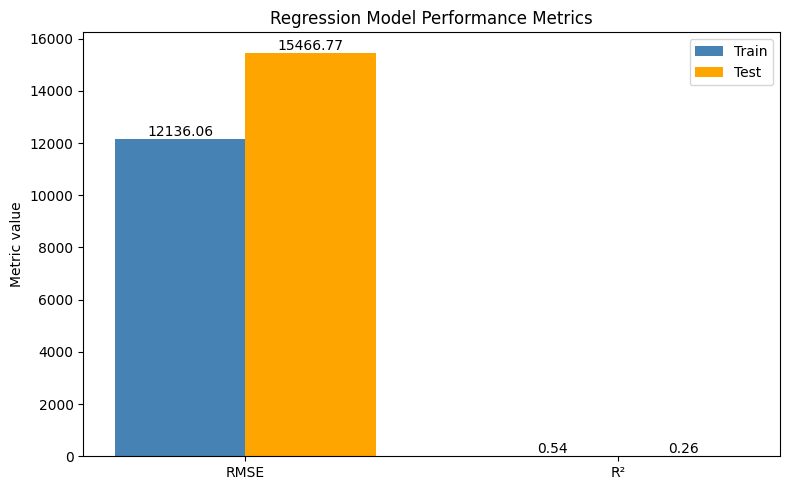

In [12]:
'''# Regression evaluation
y_pred_reg = reg_model.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n--- Regression Results ---")
print("RMSE:", rmse)
print("R2:", r2)'''

# Evaluate the model
y_pred_train_reg = reg_model.predict(X_train_reg)
y_pred_test_reg = reg_model.predict(X_test_reg)

# Evaluate the regression model's performance
train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train_reg))
test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_reg))
r2_train = r2_score(y_train_reg, y_pred_train_reg)
r2_test = r2_score(y_test_reg, y_pred_test_reg)

print("\nModel Evaluation:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R-squared: {r2_train:.2f}")
print(f"Test R-squared: {r2_test:.2f}")

# Prepare data
metrics = ["RMSE", "R²"]
train_values = [train_rmse, r2_train]
test_values = [test_rmse, r2_test]

x = np.arange(len(metrics))
width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, train_values, width, label="Train", color="steelblue")
bars2 = plt.bar(x + width/2, test_values, width, label="Test", color="orange")

plt.ylabel("Metric value")
plt.title("Regression Model Performance Metrics")
plt.xticks(x, metrics)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
                 ha="center", va="bottom")

plt.legend()
plt.tight_layout()
plt.show()



Taking a look at the regression results, we see that `Train R-squared: 0.54`. From theory we know that $R^2$ determines how good the regression predictions approximate real data.
- $R_{train}^2 = 0.54$ is strong, as the model is able to explain 54% of cost variation on the training set.
- On the other hand, $R_{test}^2 = 0.26$ is much lower, as it reflects that the model is only able to explain 26% of cost variation on the test set (unknown data)

 With this results, we could say that the model is learning real structure (because $R_{test}^2 = 0.26$ is a considerable number), but as it is not high, the model could be capturing specific patterns from the training data that are not able to generalize. From the medical costs perspective, this makes total sense, as costs tend to be extremely skewed. This is proven by Malehi et al. in [*Statistical models for the analysis of skewed healthcare cost data: a simulation study*](https://link.springer.com/content/pdf/10.1186/s13561-015-0045-7.pdf) where they state the following:

 *"Healthcare costs data demonstrate the substantial positive skewness and are sometimes characterized by the use of large resources with zero cost."*

With all this information, we can conclude saying that from a predictive perspective, our model is trustworthy.

 Now, connecting this regression task with Obermeyer et al. work, we realize that we still haven't proved anything regarding faireness, because as they prove on their paper, the model predicts the wrong thing, but not poorly (it is actually the contrary). So, we need to conduct a conditional analysis (we will later on explain why)

### Classification Evaluation

Recall that we aimed for a classification model that predicts high health burden at year *t* given information from year *t-1*


--- Classification Metrics ---
Accuracy: 0.904
Precision: 0.838
Recall: 0.861
F1-score: 0.850
ROC AUC: 0.938
Log Loss: 0.276

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6697
           1       0.84      0.86      0.85      3060

    accuracy                           0.90      9757
   macro avg       0.89      0.89      0.89      9757
weighted avg       0.91      0.90      0.90      9757



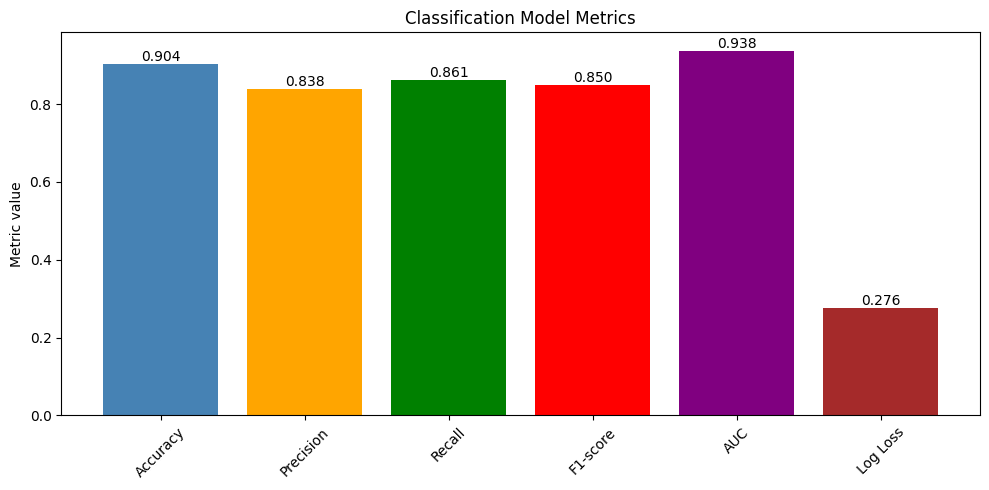

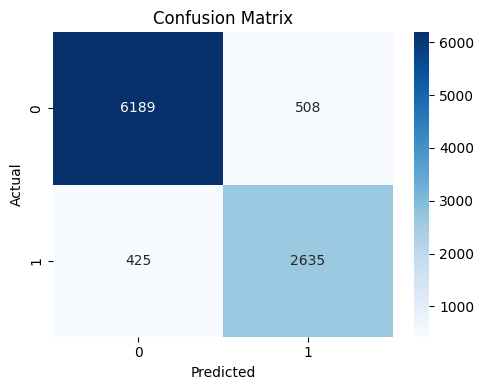

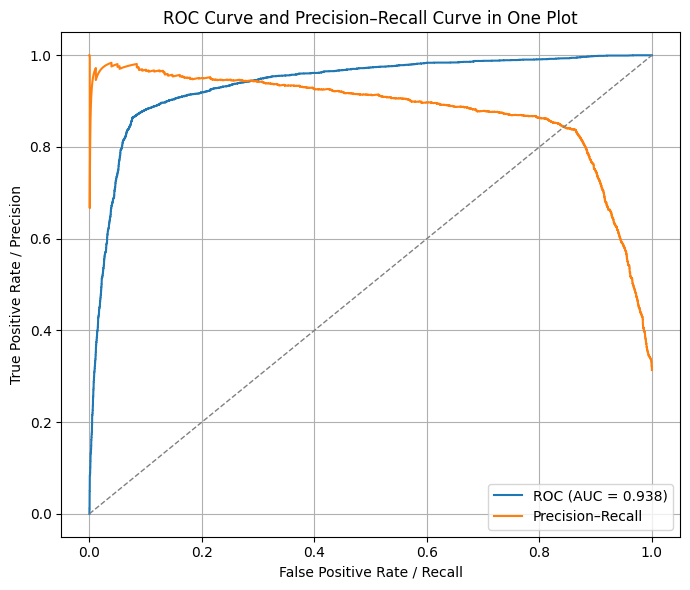

In [13]:
'''# Classification evaluation
y_pred_proba = clf_model.predict_proba(X_test_clf)[:, 1]
auc = roc_auc_score(y_test_clf, y_pred_proba)

print("\n--- Classification Results ---")
print("AUC:", auc)
print(classification_report(y_test_clf, clf_model.predict(X_test_clf)))'''

# Predictions
y_pred = clf_model.predict(X_test_clf)
y_pred_proba = clf_model.predict_proba(X_test_clf)[:, 1]

# Metrics
acc = accuracy_score(y_test_clf, y_pred)
prec = precision_score(y_test_clf, y_pred)
rec = recall_score(y_test_clf, y_pred)
f1 = f1_score(y_test_clf, y_pred)
auc = roc_auc_score(y_test_clf, y_pred_proba)
ll = log_loss(y_test_clf, y_pred_proba)

print("\n--- Classification Metrics ---")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {auc:.3f}")
print(f"Log Loss: {ll:.3f}")
print("\nClassification report:")
print(classification_report(y_test_clf, y_pred))

# Plotting the metric data results to make it interactive
metric_names = ["Accuracy", "Precision", "Recall", "F1-score", "AUC", "Log Loss"]
metric_values = [acc, prec, rec, f1, auc, ll]

# Assign a different color to each bar
colors = ["steelblue", "orange", "green", "red", "purple", "brown"]

plt.figure(figsize=(10, 5))
bars = plt.bar(metric_names, metric_values, color=colors)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.3f}",
             ha="center", va="bottom")

plt.ylabel("Metric value")
plt.title("Classification Model Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test_clf, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Cálculo de curvas
fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
prec_curve, rec_curve, _ = precision_recall_curve(y_test_clf, y_pred_proba)
auc = roc_auc_score(y_test_clf, y_pred_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})") # ROC
plt.plot(rec_curve, prec_curve, label="Precision–Recall") # Precision–Recall
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1) # diagonal line for ROC reference

plt.xlabel("False Positive Rate / Recall")
plt.ylabel("True Positive Rate / Precision")
plt.title("ROC Curve and Precision–Recall Curve in One Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see from the results, the model yields an excellent Area Under the ROC curve, as `ROC_AUC = 0.938`. [Google](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) defines this metric as the probabilistic quantity that the model ranks the positive higher than the negative, given 2 random examples (positive and negative) In practical terms, this means that if we randomly pick one high need patient and one low need patient, the model assigns the attribute *"high need patient"* **correctly** *94%* of the times, this showcases a strong discrimination ability.

Regarding the recall, we know from lectures that it is defined as the ratio between the correctly classified actual positives and all actual positives (i.e., $\frac{TP}{TP + FN}$: $\text{TP = True Positives}$, $\text{FN = False Negatives}$) So taking into account this definition, a `recall = 0.861` implies that the model identifies correctly 86.1% of the patients. This is very important from the clinical point of view, as missing high need patients is expensive.

Moving on to the model's precision, i.e., the ratio between all the model's positive classifications that are actually positive, is defined as: $\frac{TP}{TP + FP}$ where $\text{FP = False Positives}$. A `precision = 0.838` denotes a solid prediction, as from the classified high need patients, around 83.8% are "truly" high need patients. This means that we are not "over reacting".

Finally, an `F1 = 0.850` confirms a balance performance between precision and recall, indicating an absence of obvious instability.

With this model we are predicting high health needs directly from the Gagné index from year `t-1` and past clinical features. This means that our classification index is actually closer to true illness. Now it is important to realize that our model can still under detect hogh need black patients, present lower recalls from one specific class and systematically assign lower predicted probabilites.

For the above reason, we now need to check the recall score for both races (black and white) as well as the average predicted probability.

In [20]:
# recall check by race
print("\n--- Recall by race ---")
for group in ['black', 'white']:
    mask = df.loc[y_test_clf.index, 'race'] == group
    print(f"{group} Recall: {recall_score(y_test_clf[mask], y_pred[mask])}")

# average predicted probability by race
test_results = X_test_clf.copy() 
test_results['true_label'] = y_test_clf # true labels
test_results['predicted_prob'] = y_pred_proba # predicted probabilities
test_results['race'] = df.loc[X_test_clf.index, 'race'] # add race aligned by index
avg_pred_prob_by_race = test_results.groupby('race')['predicted_prob'].mean() # compute the avg predicted prob. by race
print("\n--- Average predicted probability by race ---")
print(avg_pred_prob_by_race)


--- Recall by race ---
black Recall: 0.9085603112840467
white Recall: 0.8515318146111548

--- Average predicted probability by race ---
race
black    0.444847
white    0.296963
Name: predicted_prob, dtype: float32


Taking a look at the results from above, we can see how the recall fro the black population is higher than their white counterpart. This means that the model correctly classified more black patients than white patients, meaning that the model is less likely to omit black patients. This is great as black patients are missed more than white patients.

Concerning the average predicted probability, we see that about 44% of the high need patients are black, while 30% are white. This implies that our model assigns higher risks to black patients overall.

## Why conditional analysis is important

What we have down so far is still an unconditional group average comparison but on predictions. 
As stated in [Obermeyer et al., Science 366, 447–453 (2019)](https://www.science.org/doi/epdf/10.1126/science.aax2342) ''''


In [15]:
df['black'] = (df['race'] == 'black').astype(int)

import statsmodels.api as sm

X = df[['gagne_sum_t', 'black']]
X = sm.add_constant(X)

y = df['cost_t']
y_log = np.log1p(df['cost_t']) # we apply the log transformation to retrieve a more reliable interpretation
model_log = sm.OLS(y_log, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                 cost_t   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2610.
Date:                Sun, 01 Mar 2026   Prob (F-statistic):               0.00
Time:                        15:58:16   Log-Likelihood:            -1.0124e+05
No. Observations:               48784   AIC:                         2.025e+05
Df Residuals:                   48781   BIC:                         2.025e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.3263      0.011    672.051      

## Fairness Analysis

In this step, we analyse whether the model’s predictions differ systematically across demographic groups (e.g., race).

We compare average predicted risk across groups and examine whether disparities exist between predicted outcomes and actual health load.

This step is crucial because predictive models may optimise their objective function while still reproducing structural inequalities. By separating model performance from fairness evaluation, we ensure a more responsible assessment of the system.

This analysis prepares the ground for explainability techniques covered in **Sessions 7 and 8**, where we studied how to interpret complex models and investigate potential sources of bias.

In [16]:
if race is not None:
    test_reg_df = X_test_reg.copy()
    test_reg_df['race'] = race.loc[X_test_reg.index]
    test_reg_df['predicted_cost'] = y_pred_test_reg
    test_reg_df['true_cost'] = y_test_reg

    print("\n--- Average Predicted Cost by Race ---")
    print(test_reg_df.groupby('race')['predicted_cost'].mean())

    print("\n--- Average True Cost by Race ---")
    print(test_reg_df.groupby('race')['true_cost'].mean())


--- Average Predicted Cost by Race ---
race
black    9700.040039
white    7331.816406
Name: predicted_cost, dtype: float32

--- Average True Cost by Race ---
race
black    9420.388350
white    7376.866883
Name: true_cost, dtype: float64


## Global Explainability (SHAP)

In this step, we apply global explainability techniques to understand overall model behaviour.

Following **Session 8 — Global Explainability and SHAP**, we use SHAP values to quantify the contribution of each feature to the model’s predictions.

SHAP provides both global explanations (feature importance across the dataset) and local explanations (feature contributions for individual cases). This allows us to:

- Identify the most influential predictors.
- Compare feature importance between the cost prediction model and the health burden model.
- Detect whether proxy variables dominate decision-making.

This step is central to our analysis, as it allows us to move from predictive performance to structural understanding.


--- SHAP Summary Plot (Regression) ---


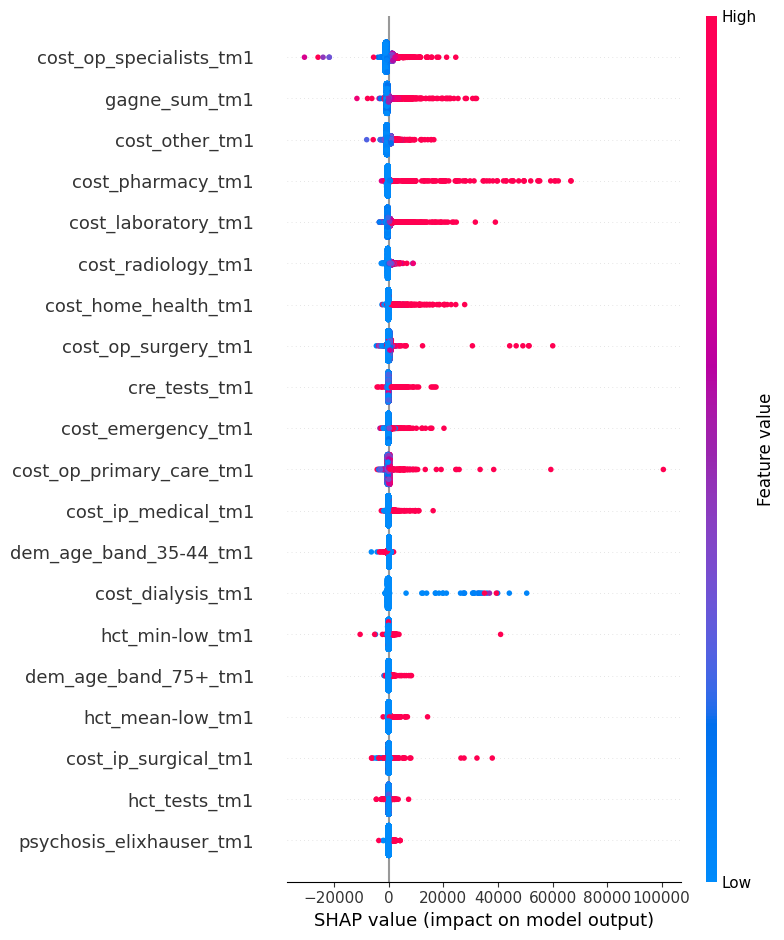


--- SHAP Summary Plot (Classification) ---


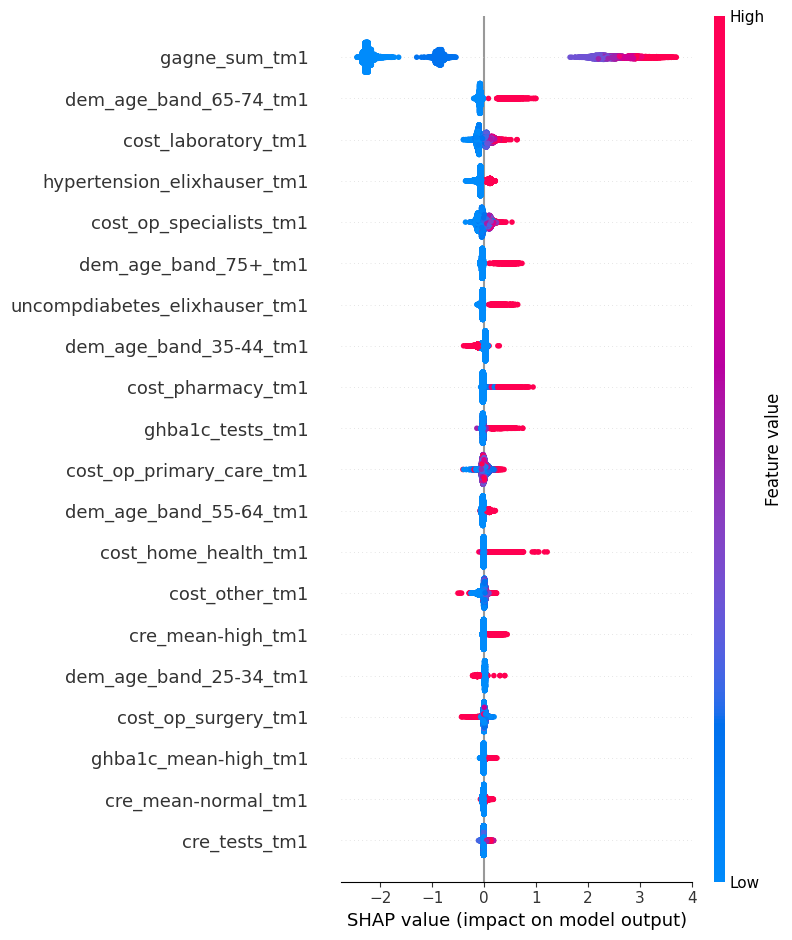

In [17]:
# Regression SHAP
explainer_reg = shap.TreeExplainer(reg_model)
shap_values_reg = explainer_reg.shap_values(X_test_reg)

print("\n--- SHAP Summary Plot (Regression) ---")
shap.summary_plot(shap_values_reg, X_test_reg)

# Classification SHAP
explainer_clf = shap.TreeExplainer(clf_model)
shap_values_clf = explainer_clf.shap_values(X_test_clf)

print("\n--- SHAP Summary Plot (Classification) ---")
shap.summary_plot(shap_values_clf, X_test_clf)

## Local Explainability (LIME)

In this step, we apply local explainability techniques to understand individual predictions.

Following **Session 7: Black Box Explainability — LIME**, we use LIME to approximate the complex model locally with a simpler interpretable model. This allows us to analyse why the model assigned a specific risk score to a particular patient.

Local explanations are especially important in healthcare contexts, where individual decisions may directly affect patient care.

By examining local explanations, we assess whether predictions are driven by clinically meaningful variables or by proxies such as past healthcare expenditure.


--- Example Local Explanation (Regression, first test case) ---


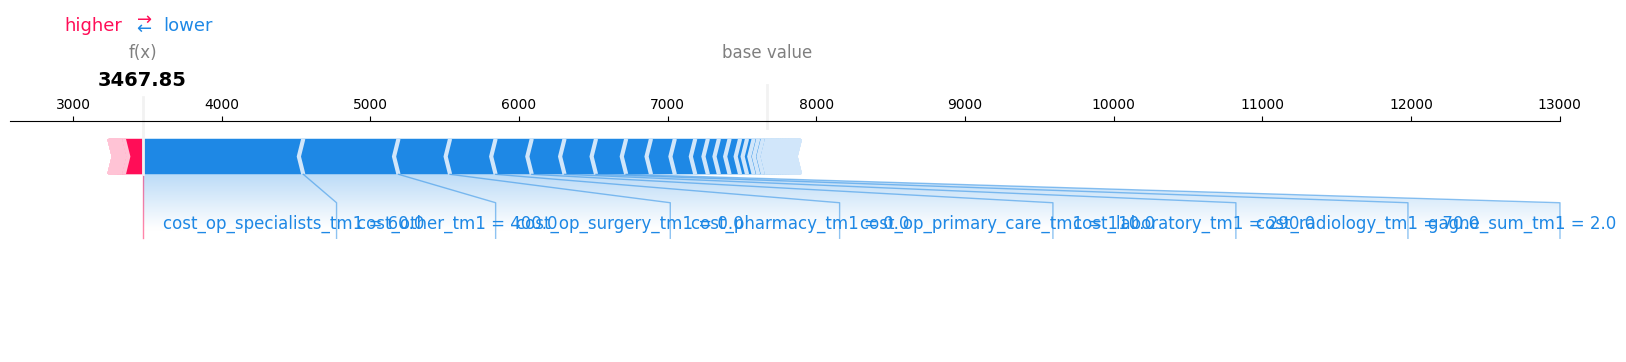

In [18]:
print("\n--- Example Local Explanation (Regression, first test case) ---")
shap.force_plot(
    explainer_reg.expected_value,
    shap_values_reg[0],
    X_test_reg.iloc[0],
    matplotlib=True
)

## Comparative Analysis and Ethical Reflection

In the final step, we compare the regression and classification models.

We analyse differences in:
- Predictive performance.
- Feature importance.
- Group-level disparities.
- Alignment between objective function and clinical need.

Through this comparison, we evaluate whether predicting healthcare cost leads to different structural behaviour than predicting health burden.

By combining predictive modelling with explainability techniques (Sessions 7 and 8), we critically assess whether the choice of prediction target introduces ethical misalignment.

This step allows us to demonstrate that the design of the prediction task itself can shape model behaviour and potentially embed systemic bias.

In [19]:
# Quick XGBoost grid-search example (uses variables defined earlier in this notebook)
# This cell runs a small CV search (cv=3) and saves the results to CSV files.
# WARNING: grid search can be slow on large datasets. Consider using a subsample or smaller `cv` for quick experiments.
from model_search import grid_search_models

# Regression example (uses X_train_reg, y_train_reg defined earlier)
res_reg = grid_search_models(X_train_reg, y_train_reg, task='regression', cv=3, n_jobs=1, verbose=1)
res_reg.to_csv('grid_search_reg_results.csv', index=False)
print('Saved regression grid-search results to grid_search_reg_results.csv')
print(res_reg)

# Classification example (uses X_train_clf, y_train_clf defined earlier)
res_clf = grid_search_models(X_train_clf, y_train_clf, task='classification', cv=3, n_jobs=1, verbose=1)
res_clf.to_csv('grid_search_clf_results.csv', index=False)
print('Saved classification grid-search results to grid_search_clf_results.csv')
print(res_clf)


Running GridSearch for: XGBRegressor
Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 